In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:

import torch
import torch.nn.functional as F

from model import OwlNet


def loss_func(batch, similarity_threshold=0.65, margin=0.0):
    batch_size = batch.shape[0]
    batch = F.normalize(batch, p=2, dim=1)  # Normalize embeddings for cosine similarity
    
    # Compute cosine similarity matrix
    similarity_matrix = torch.mm(batch, batch.T)  # Shape: (batch_size, batch_size)
    
    # Mask out self-similarity
    mask = torch.eye(batch_size, device=batch.device).bool()
    similarity_matrix.masked_fill_(mask, -1)  # Set diagonal to -1 so it's not considered a neighbor
    
    # Find nearest neighbors based on similarity threshold
    positive_mask = similarity_matrix >= similarity_threshold  # Positive pairs
    negative_mask = similarity_matrix < similarity_threshold  # Negative pairs
    
    # Loss computation
    positive_loss = (1 - similarity_matrix)[positive_mask].mean() if positive_mask.any() else torch.tensor(0.0, device=batch.device)
    negative_loss = F.relu(similarity_matrix[negative_mask] - margin).mean() if negative_mask.any() else torch.tensor(0.0, device=batch.device)
    

    loss = positive_loss + negative_loss
    return loss

Processing file 1_Barn_Owl_hissing_002B_00-60_clean_HPF_500Hz


  0%|          | 0/674 [00:00<?, ?it/s]

Processing file 1_Barn_Owl_hissing_005_00-60_clean_HPF_500Hz


  0%|          | 0/752 [00:00<?, ?it/s]

Processing file 1_Barn_Owl_hissing_003_00-60_clean_HPF_500Hz


  0%|          | 0/1029 [00:00<?, ?it/s]

Processing file 1_Barn_Owl_hissing_004_00-60_clean_HPF_500Hz


  0%|          | 0/920 [00:00<?, ?it/s]

torch.Size([1, 750, 87])


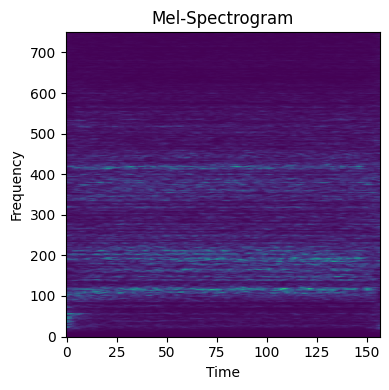

In [2]:
from data import load_data
from data_utils import display_melspec


drop = 0.0
embed_sz = 64
epochs = 105
# lr = 2e-6
lr = 5e-6
batch_sz = 512
debug = False
spec_height = 750

owlet_train, owlet_test, dataset = load_data(
    "lotek_owl_data",
    train_test_split=[1.0, 0],
    batch_sz=batch_sz,
    debug=debug,
    spec_height=spec_height
)
# owlet_train, owlet_test = load_toy_data(batch_sz=batch_sz, train_test_split=[1.0, 0])
# show sample image
img = next(iter(owlet_train))[0][0]
display_melspec(img, size=(4, 4), colorbar=False)

model_name = f"model_{len(owlet_train) * batch_sz}.datapoints_{epochs}.epochs"

In [4]:
import torch.nn.functional as F
from model import OwlNet


owlnet = OwlNet(embed_sz, drop).cuda()


optimizer = torch.optim.AdamW(owlnet.parameters(), betas=(0.9, 0.999), lr=lr)
loss_function = loss_func
for epoch in range(epochs):
    owlnet.train()
    for i, (train_batch, _) in enumerate(owlet_train):
        batch_sz = train_batch.shape[0]
        optimizer.zero_grad()
        train_batch = train_batch.cuda()
        embeds = owlnet(train_batch)
        embeds = F.normalize(embeds, p=2, dim=1)  # Normalize embeddings for cosine similarity
        loss = loss_function(embeds)
        loss.backward()
        optimizer.step()
        print(f"Train Epoch {epoch + 1} ({i}/{len(owlet_train)}): Loss {loss.item()}", end="\r")

torch.save(owlnet.state_dict(), f"{model_name}.pth")